In [39]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

import json
import pickle as pkl
import warnings
from typing import List

import numpy as np
import scipy
from hist import Hist

def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [40]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
! ls ../eos/

Aug19_hww_2017                  July23_triggerSF_2016
Aug19_hww_2018                  July23_triggerSF_2016APV
Aug19_triggerSF_alpha_2016      July23_triggerSF_2017
Aug19_triggerSF_alpha_2016APV   July23_triggerSF_2018
Aug19_triggerSF_alpha_2017      July26_hww_2016
Aug19_triggerSF_alpha_2018      July26_hww_2016APV
July18_hww_2016                 July26_hww_2017
July18_hww_2016APV              July26_hww_2018
July18_hww_2016APV_BKGS         June11_LP_2017
July18_hww_2016_BKGS            June21_zll_2016
July18_hww_2017                 June21_zll_2016APV
July18_hww_2017_BKGS            June21_zll_2017
July18_hww_2018                 June21_zll_2018
July18_hww_2018_BKGS            May27_fakes_cutbased_2017
July18_hww_uselooselep_2016     May27_fakes_mva_2017
July18_hww_uselooselep_2016APV  May28_electronmva_nometcut_2017
July18_hww_uselooselep_2017     model.onnx
July18_hww_uselooselep_2018     model_v35_12_14.onnx
July1_eleisoSF_2017             model_v35_26.onnx


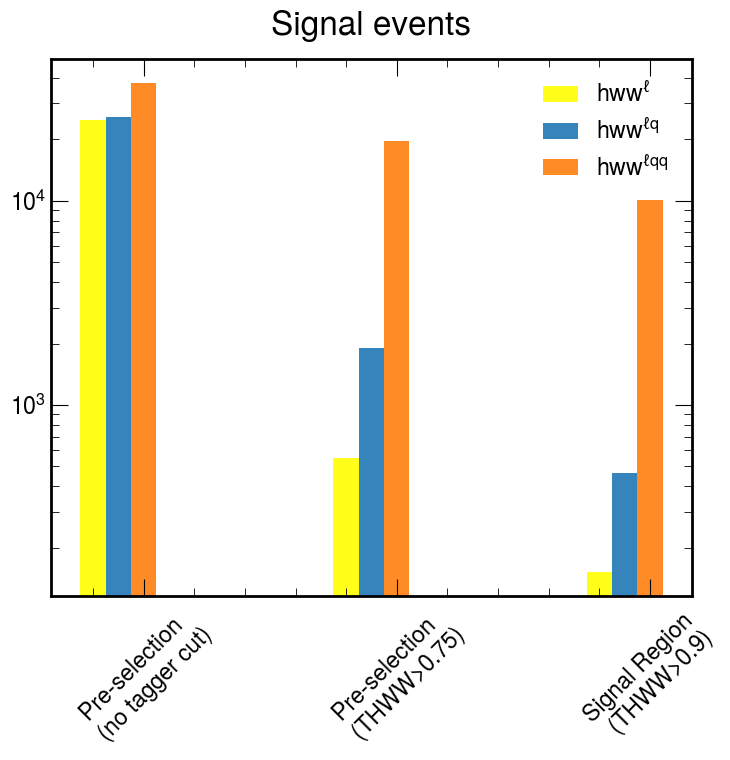

In [988]:
############### for signal

year = "2017"
parquets = glob.glob(f"../eos/June11_LP_{year}/*/outfiles/*.parquet")

df = pd.read_parquet(parquets)
df["THWW"] = get_finetuned_score(df, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")

is_hww_l = (df["num_m_quarks"]==0)

is_hww_lq = (df["num_m_quarks"]==1)
is_hww_lqq = (df["num_m_quarks"]==2)

%matplotlib inline
plt.rcParams.update({"font.size": 20})

color_by_sample = {
    0: "yellow", 
    1: "tab:blue",
    2: "tab:orange",
}

regions = {
    "Pre-selection \n (no tagger cut)": 0,
    "Pre-selection \n (THWW>0.75)": 0.75,
    "Signal Region \n (THWW>0.9)": 0.9,
}

samples = range(3)

bar_width = 0.1

fig, ax = plt.subplots(figsize=(8, 8))

for iregion, (region, cut) in enumerate(regions.items()):

    for i, (key, var) in enumerate(
        {
            r"$hww^{\ell}$": is_hww_l,
            r"$hww^{{\ell}q}$": is_hww_lq,
            r"$hww^{{\ell}qq}$": is_hww_lqq,
        }.items()
    ):
        X = (var & (df["THWW"]>cut)).sum()
        bars = ax.bar(
            iregion + i * bar_width, 
            X, 
            bar_width, 
            color=color_by_sample[i],
            label=key,
            alpha=0.9,
        )
        ax.axhline(y=0, color='black', linestyle='--')

# Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
# ax.set_ylim(-2.5, 2.5)

# Adjust the number of x-tick labels to match the number of groups
plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

# Add a legend
handles, labels = ax.get_legend_handles_labels()[0][:len(samples)], ax.get_legend_handles_labels()[1][:len(samples)]
ax.legend(handles, labels, loc='upper right')

ax.set_title("Signal events", pad=17)

plt.tight_layout()
# plt.show()
ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/LP_mquarks_sig.pdf")    

is_top_l:  112444
is_top_lq:  23086
is_top_lqq:  7161
is_top_lb:  829921
is_top_lbq:  49426
is_top_lbqq:  7575


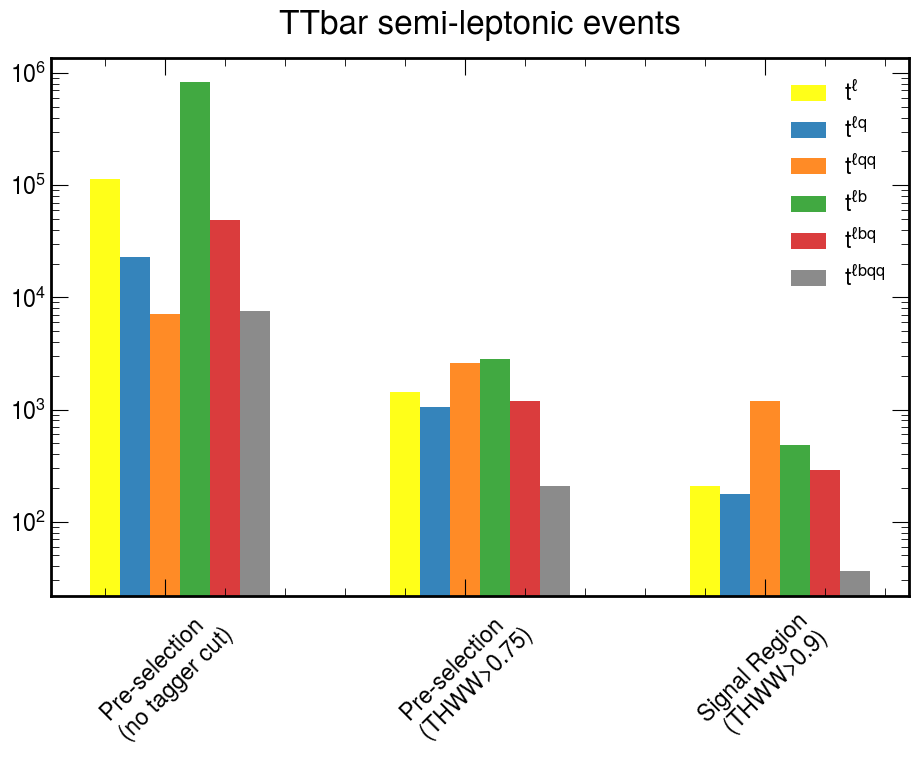

In [1083]:
############### for top

year = "2017"
parquets = glob.glob(f"../eos/June1_LPvalidation_{year}/*/outfiles/*.parquet")

df = pd.read_parquet(parquets)
df["THWW"] = get_finetuned_score(df, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")


is_top_l = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]==0)

is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)
is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)

is_top_lb = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]>=1)
is_top_lbq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]>=1)
is_top_lbqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]>=1)

print("is_top_l: ", is_top_l.sum())
print("is_top_lq: ", is_top_lq.sum())
print("is_top_lqq: ", is_top_lqq.sum())
print("is_top_lb: ", is_top_lb.sum())
print("is_top_lbq: ", is_top_lbq.sum())
print("is_top_lbqq: ", is_top_lbqq.sum())

%matplotlib inline
plt.rcParams.update({"font.size": 20})

color_by_sample = {
    0: "yellow", 
    1: "tab:blue",
    2: "tab:orange",
    3: "tab:green",
    4: "tab:red",
    5: "tab:grey",
}

regions = {
    "Pre-selection \n (no tagger cut)": 0,
    "Pre-selection \n (THWW>0.75)": 0.75,
    "Signal Region \n (THWW>0.9)": 0.9,
}

# samples = np.unique(df["fj_Top_nquarksnob"], return_counts=True)[0]
samples = range(6)

bar_width = 0.1

fig, ax = plt.subplots(figsize=(10, 8))

for iregion, (region, cut) in enumerate(regions.items()):

    for i, (key, var) in enumerate(
        {
            r"$t^{\ell}$": is_top_l,
            r"$t^{{\ell}q}$": is_top_lq,
            r"$t^{{\ell}qq}$": is_top_lqq,
            r"$t^{{\ell}b}$": is_top_lb,
            r"$t^{{\ell}bq}$": is_top_lbq,
            r"$t^{{\ell}bqq}$": is_top_lbqq,
        }.items()
    ):
        X = (var & (df["THWW"]>cut)).sum()
        bars = ax.bar(
            iregion + i * bar_width, 
            X, 
            bar_width, 
            color=color_by_sample[i],
            label=key,
            alpha=0.9,
        )
        ax.axhline(y=0, color='black', linestyle='--')

# Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
# ax.set_ylim(-2.5, 2.5)

# Adjust the number of x-tick labels to match the number of groups
plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

# Add a legend
handles, labels = ax.get_legend_handles_labels()[0][:len(samples)], ax.get_legend_handles_labels()[1][:len(samples)]
ax.legend(handles, labels, loc='upper right')

ax.set_title("TTbar semi-leptonic events", pad=17)

plt.tight_layout()
# plt.show()
ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/LP_mquarks_TTbar.pdf")    

In [856]:
for key in df:
    if "isT" in key:
        print(key)

fj_isTop
fj_isTop_matched
fj_isTop_W_lep_b
fj_isTop_W_lep
fj_isTop_W_ele_b
fj_isTop_W_ele
fj_isTop_W_mu_b
fj_isTop_W_mu
fj_isTop_W_tau_b
fj_isTop_W_tau


In [770]:
# import vector 
# # Create 4-vectors from px, py, pz, and energy
# vec = vector.array({
#     "px": pxs,
#     "py": pys,
#     "pz": pzs,
#     "E": Es
# })

# # Now you can access pt, eta, phi, and energy components
# pts = vec.pt
# etas = vec.eta
# phis = vec.phi
# energies = vec.E  # Energy remains unchanged

# # Stack these new vectors back into a new array
# new_pf_cands = np.stack([pts, etas, phis, energies], axis=-1)


## Retrieve the pfcands, genquark, and ak8 jet info

In [453]:
! ls lol/outfiles

0-1.pkl             0-10old_mu.parquet  0-20.pkl            0-25.pkl
0-10old.pkl         0-1_ele.parquet     0-20_ele.parquet    0-25_ele.parquet
0-10old_ele.parquet 0-1_mu.parquet      0-20_mu.parquet     0-25_mu.parquet


In [1137]:
############### for signal

year = "2017"
parquets = glob.glob("lol/02/0-20_*.parquet")

df = pd.read_parquet(parquets)
# plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP_mquarks_sig.pdf")

In [1062]:
# fig, ax = plt.subplots(figsize=(8, 8))

# ax.hist(
#     df["topsdr"],
#     bins=np.linspace(0,3.14,20),
#     histtype="step",
#     lw=2,
# )

# ax.set_xlabel(r"d$\phi$(first top, second top)")
# ax.set_ylabel("Events")
# plt.savefig("/Users/fmokhtar/Desktop/AN_2024/LP/topsdphi.pdf")

In [1063]:
year = "2017"
parquets = glob.glob(f"../eos/June11_LP_{year}/*/outfiles/*.parquet")

df1 = pd.read_parquet(parquets)
df1["THWW"] = get_finetuned_score(df1, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")

In [1093]:
year = "2017"
parquets = glob.glob(f"../eos/June1_LPvalidation_{year}/*/outfiles/*.parquet")

df1 = pd.read_parquet(parquets)
df1["THWW"] = get_finetuned_score(df1, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")

In [1119]:
df = df1[:200000].copy()

In [1065]:
# mask signal if you want
is_hww_l = (df["num_m_quarks"]==0)

is_hww_lq = (df["num_m_quarks"]==1)
is_hww_lqq = (df["num_m_quarks"]==2)

df = df[is_hww_lq | is_hww_lqq]

In [1139]:
# mask top if you want

is_top_l = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]==0)

is_top_lb = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]>=1)
is_top_lbq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]>=1)
is_top_lbqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]>=1)

is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)
is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)
    
print("is_top_l: ", is_top_l.sum())
print("is_top_lb: ", is_top_lb.sum())
print("is_top_lbq: ", is_top_lbq.sum())
print("is_top_lbqq: ", is_top_lbqq.sum())
print("is_top_lq: ", is_top_lq.sum())
print("is_top_lqq: ", is_top_lqq.sum())

# df = df[is_top_lqq | is_top_lq]
df = df[is_top_lbqq | is_top_lbq]

is_top_l:  0
is_top_lb:  0
is_top_lbq:  336
is_top_lbqq:  51
is_top_lq:  0
is_top_lqq:  0


In [1140]:
# (1) PFcands

pxs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("px")].values
pys = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("py")].values
pzs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("pz")].values
Es = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("energy")].values

pf_cands = np.stack([pxs,pys,pzs,Es], axis=-1)

print("pf_cands", pf_cands.shape)

# (2) ak8 jet, and the THWW score

ak8_jets = np.stack([df["LP_fj_pt"].values, df["LP_fj_eta"].values, df["LP_fj_phi"].values, df["LP_fj_energy"].values], axis=-1)
print("ak8_jets", ak8_jets.shape)

# print("THWW", df["THWW"].shape)

# (3) genQuarks

etas = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("eta")].values
phis = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("phi")].values

gen_parts_eta_phi = np.stack([etas,phis], axis=-1)
print("gen_parts_eta_phi", gen_parts_eta_phi.shape, " (# events, # quarks, eta&phi)")

# # (4) bgenQuarks

etas = df.loc[:,df.columns.str.contains("LP_bquark") & df.columns.str.contains("eta")].values
phis = df.loc[:,df.columns.str.contains("LP_bquark") & df.columns.str.contains("phi")].values

bgen_parts_eta_phi = np.stack([etas,phis], axis=-1)
print("bgen_parts_eta_phi", gen_parts_eta_phi.shape, " (# events, # quarks, eta&phi)")

pf_cands (387, 150, 4)
ak8_jets (387, 4)
gen_parts_eta_phi (387, 2, 2)  (# events, # quarks, eta&phi)
bgen_parts_eta_phi (387, 2, 2)  (# events, # quarks, eta&phi)


In [1142]:
# mask signal if you want
df = df[df["num_m_quarks"]>0]

KeyError: 'num_m_quarks'

In [1135]:
# select the closest gen quark
indices = get_dRs_columnar(gen_parts_eta_phi, ak8_jets.reshape(-1,4,1)).argmin(axis=1)
gen_parts_eta_phi = gen_parts_eta_phi[np.arange(len(gen_parts_eta_phi)), indices, :].reshape(-1,1,2)

In [843]:
def ang_dist(phi1, phi2):
    phi1 = phi1 % (2. * np.pi)
    phi2 = phi2 % (2. * np.pi)
    dphi = phi1 - phi2
    if(len(dphi.shape) > 0):
        dphi[dphi < -np.pi] += 2.*np.pi
        dphi[dphi > np.pi] -= 2.*np.pi
    else:
        if(dphi < -np.pi): dphi += 2.*np.pi
        if(dphi > np.pi): dphi -= 2.*np.pi

    return dphi

def get_dRs_columnar(gen_eta_phi, j_4vec):

    dR = np.sqrt(np.square(gen_eta_phi[:, :,0] - j_4vec[:, 1]) + 
            np.square(ang_dist(gen_eta_phi[:, :,1], j_4vec[:, 2] )))
    return dR

get_dRs_columnar(bgen_parts_eta_phi, ak8_jets.reshape(-1,4,1))

array([[3.32028912, 0.05300039],
       [3.58958559, 1.49909957],
       [2.69278645, 0.06674643],
       ...,
       [1.1913639 , 1.52732619],
       [0.32327933, 2.88844479],
       [0.22044421, 2.06907954]])

In [1143]:
# concatenate both bgen quarks

gen_parts_eta_phi = np.concatenate([gen_parts_eta_phi,bgen_parts_eta_phi], axis=1)
gen_parts_eta_phi.shape

(387, 4, 2)

In [1131]:
# concatenate the closest bgen quark

def ang_dist(phi1, phi2):
    phi1 = phi1 % (2. * np.pi)
    phi2 = phi2 % (2. * np.pi)
    dphi = phi1 - phi2
    if(len(dphi.shape) > 0):
        dphi[dphi < -np.pi] += 2.*np.pi
        dphi[dphi > np.pi] -= 2.*np.pi
    else:
        if(dphi < -np.pi): dphi += 2.*np.pi
        if(dphi > np.pi): dphi -= 2.*np.pi

    return dphi

def get_dRs_columnar(gen_eta_phi, j_4vec):

    dR = np.sqrt(np.square(gen_eta_phi[:, :,0] - j_4vec[:, 1]) + 
            np.square(ang_dist(gen_eta_phi[:, :,1], j_4vec[:, 2] )))
    return dR

indices = get_dRs_columnar(bgen_parts_eta_phi, ak8_jets.reshape(-1,4,1)).argmin(axis=1)

matched_bgen = bgen_parts_eta_phi[np.arange(len(bgen_parts_eta_phi)), indices, :].reshape(-1,1,2)
gen_parts_eta_phi = np.concatenate([gen_parts_eta_phi,matched_bgen], axis=1)
gen_parts_eta_phi.shape

(387, 3, 2)

## Initiate a LundReweigher

In [1149]:
gen_parts_pdg_ids = np.zeros([len(gen_parts_eta_phi), 3, 1])

In [1153]:
gen_parts_pdg_ids[:,-1] = 5

In [1158]:
giveb = True

#use small number of events for the example, but generally advisable to use larger sample
max_evts = 5_000

import sys, os
sys.path.insert(0, '')
sys.path.append("LundReweighting")
from LundReweighting.utils.Utils import *

""" An example how to use the Lund Plane reweighting  code. 
Computes reweighting factors for an example signal. 
Uses them to compute the efficiency and uncertainty of a given substructure cut"""

######################## Setup 

#Input file 
fname = "LundReweighting/data/example_signal.h5"
f_ratio_name = 'LundReweighting/data/ratio_2017.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset 
d = Dataset(f_sig, dtype = 1)
d.compute_obs()

#Main class for reweighting utilities
LP_rw = LundReweighter(f_ratio = f_ratio)

################### Compute reweighting factors

#PF candidates in the AK8 jet for each event (list of (px,py,pz,E))
pf_cands = pf_cands[:max_evts]
print("Running on %i events" % len(pf_cands))

#Generator level quarks from hard process 
gen_parts_eta_phi = gen_parts_eta_phi[:max_evts]

#4 vector of AK8 jets we are calibrating
ak8_jets = ak8_jets[:max_evts]

#Nominal event weights of the MC, (assume every event is weight '1' for this example)
nom_weights = np.ones(len(pf_cands))

#Compute reweighting factors and all systematic variations
if giveb is True:
    print("Will include b pdgid")
    LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets, gen_parts_pdg_ids)
else:
    LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets)


#multiply Lund plane weights with nominal event weights
for key in LP_weights.keys():
    if('nom' in key or 'up' in key or 'down' in key):
        if(isinstance(LP_weights[key], np.ndarray)) : LP_weights[key] *= nom_weights


#Fraction of prongs that are not well matched to subjets (want this to be low)
print("Bad match frac %.2f" % np.mean(LP_weights['bad_match']))
#Fraction of prongs that are still not well matched after reclustering with varied number of prongs
print("Reclustered bad match frac %.2f" % np.mean(LP_weights['reclust_still_bad_match']))

Running on 387 events
Will include b pdgid
Only 387 jets given, will not include LP distortion systematic
Bad match frac 0.32
Reclustered bad match frac 0.24


In [1157]:
score_thresh = 0.75

score = df["THWW"].values[:max_evts]
score_cut = score < score_thresh

###### Use weights to compute efficiency of a cut

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = nom_weights)

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights['nom'])

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
#separately for each MC sample rather than a single 'SF'


######  Compute uncertainties on the efficiency from the various weight variations ##############

#statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
#take std dev to determine unc

nToys = LP_weights['stat_vars'].shape[1]
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

#if mean of toys is biased, also include it as an unc (should be zero)
eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))

#Other systematics come from up/down variations of the weights
sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
sys_uncs = dict()

for sys in sys_keys: sys_uncs[sys] = [0.,0.]

#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(cut, weights = weights_up)
    eff_down =  np.average(cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down

for sys in sys_keys:
    unc_up, unc_down = get_uncs(score_cut, LP_weights[sys + '_up'], LP_weights[sys + '_down'], eff_rw)
    sys_uncs[sys] = [unc_up, unc_down]


#Print uncertainty breakdown
eff_str = "Calibrated efficiency  is %.3f +/- %.3f (stat) +/- %.3f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

for sys in sys_keys:
    eff_str += " %.3f/%.3f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
    up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
    down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
    tot_unc_up += up_var**2
    tot_unc_down += down_var**2

tot_unc_up = tot_unc_up**0.5
tot_unc_down = tot_unc_down**0.5

#Print final calibrated efficiency and total uncertaintiy
eff_str += "\n Original %.3f, Calibrated %.3f +%.3f/-%.3f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

print(eff_str)
f_ratio.Close()

KeyError: 'THWW'

In [ ]:
# Nominal efficiency: eff in MC
# Calibrated efficiency: eff in data
# We reweight the efficiency in MC to look like the data
# Add more decimal points to see the unc.
# SF is very close to 1! follow up with Oz
# check at different cut

(array([  74.,  299.,  731., 1275.,  932.,  637.,  372.,  218.,  153.,
         107.,   49.,   40.,   27.,   21.,   12.,   11.,    9.,    7.,
           4.]),
 array([0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
        3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ]),
 <BarContainer object of 19 artists>)

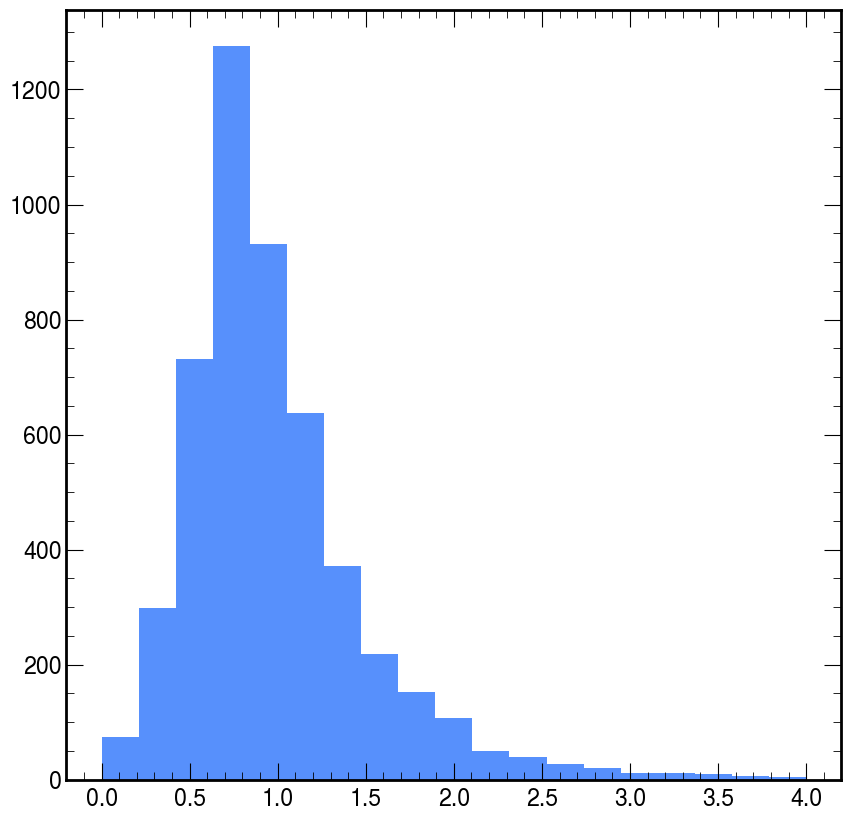

In [975]:
plt.hist(
    LP_weights["nom"],
    bins=np.linspace(0,4,20),
)

In [366]:
msk = []
for l in [x.subjet_match for x in LP_weights["reclust_nom"]]:
    if len(l)==2:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)
len(msk)

14736

In [374]:
(msk!=1).sum()

1150

In [363]:
sub_matching_bool = []
for x in np.array(LP_weights["reclust_nom"])[msk]:
    for y in x.subjet_match:
        sub_matching_bool.append(y)
sub_matching_bool = np.array(sub_matching_bool)
print("sub_matching_bool", sub_matching_bool.shape)

dRs = []
for x in np.array(LP_weights["reclust_nom"])[msk]:
    for y in x.subjet_dRs:
        dRs.append(y)
dRs = np.array(dRs)
print("dRs", dRs.shape)

sub_matching_bool (27172,)
dRs (27172,)


In [369]:
tot = msk.sum()*2
((msk!=1).sum() + len(dRs)) / tot

1.0423229795377595

13586

Text(1, 0, '$\\Delta$R(gen quark,subjet)')

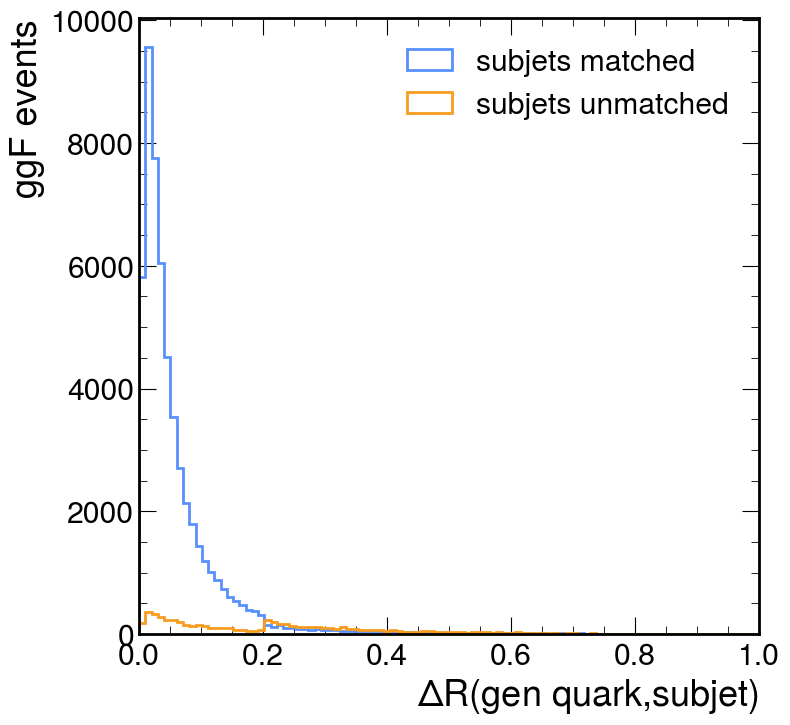

In [338]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(dRs[sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets matched")
ax.hist(dRs[~sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets unmatched")

ax.set_xlim(0,1)
ax.set_ylabel("TTbar events")
ax.legend()
ax.set_xlabel(r"$\Delta$R(gen quark,subjet)")

In [208]:
LP_weights["nom"].shape

(37359,)

In [209]:
LP_weights["nom"]

array([0.73024492, 1.16708584, 0.74874257, ..., 0.87880555, 1.11122473,
       0.64491165])

In [174]:
pd.DataFrame(LP_weights["nom"], columns=["LP_weight"]).to_parquet(f"LP_{ch}_{year}.parquet")

In [211]:
if max_evts == -1:
    score = df["THWW"].values
else:
    score = df["THWW"].values[:max_evts]
score_cut = score > 0.905

###### Use weights to compute efficiency of a cut

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = nom_weights)

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights['nom'])

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
#separately for each MC sample rather than a single 'SF'


######  Compute uncertainties on the efficiency from the various weight variations ##############

#statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
#take std dev to determine unc

nToys = LP_weights['stat_vars'].shape[1]
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

#if mean of toys is biased, also include it as an unc (should be zero)
eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Other systematics come from up/down variations of the weights
sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
sys_uncs = dict()

for sys in sys_keys: sys_uncs[sys] = [0.,0.]

#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(cut, weights = weights_up)
    eff_down =  np.average(cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down

for sys in sys_keys:
    unc_up, unc_down = get_uncs(score_cut, LP_weights[sys + '_up'], LP_weights[sys + '_down'], eff_rw)
    sys_uncs[sys] = [unc_up, unc_down]

#Print uncertainty breakdown
eff_str = "Calibrated efficiency  is %.2f +/- %.2f (stat) +/- %.2f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

for sys in sys_keys:
    eff_str += " %.2f/%.2f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
    up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
    down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
    tot_unc_up += up_var**2
    tot_unc_down += down_var**2



tot_unc_up = tot_unc_up**0.5
tot_unc_down = tot_unc_down**0.5
print()
#Print final calibrated efficiency and total uncertaintiy
eff_str += "\n Original %.2f, Calibrated %.2f +%.2f/-%.2f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

print(eff_str)
f_ratio.Close()

Nominal efficiency 0.255, Corrected efficiency 0.242, SF (corrected / nom) 0.951
Stat variation toys eff. avg 0.242, std dev 0.005
Pt variation toys eff. avg 0.242, std dev 0.000

Calibrated efficiency  is 0.24 +/- 0.01 (stat) +/- 0.00 (pt) 0.00/0.00 (sys) 0.00/0.00 (bquark) 0.00/-0.01 (prongs) -0.06/0.02 (unclust) 0.00/-0.01 (distortion)
 Original 0.26, Calibrated 0.24 +0.02/-0.06 

